In [45]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

from tvb.simulator.lab import *
from tvb.simulator.backend.theano import TheanoBackend

from tvb_inversion.base.observation_models import linear

from tvb_inversion.pymc3.prior import Pymc3Prior
from tvb_inversion.pymc3.stats_model import Pymc3Model
from tvb_inversion.pymc3.inference import EstimatorPYMC
from tvb_inversion.pymc3.plot import plot_posterior_samples

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#conn = connectivity.Connectivity.from_file()
conn = connectivity.Connectivity()
conn.weights = np.array([[0., 2.], [2., 0.]])
conn.region_labels = np.array(["R1", "R2"])
conn.centres = np.array([[0.1, 0.1, 0.1], [0.2, 0.1, 0.1]])
conn.tract_lengths = np.array([[0., 2.5], [2.5, 0.]])
conn.configure()

sim = simulator.Simulator(
    model=models.oscillator.Generic2dOscillator(a=np.array([1.5])),
    connectivity=conn,
    coupling=coupling.Difference(),
    integrator=integrators.HeunStochastic(
        dt=1.0,
        noise=noise.Additive(
            nsig=np.array([1e-4]),
            noise_seed=42
        )
    ),
    monitors=[monitors.Raw()],
    simulation_length = 250
)

In [11]:
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 0ca10a8a-0709-4788-b288-25405c2a42fe
coupling,Difference gid: 32ff059b-0c25-4781-8eb1-a37a7dbe6bae
gid,UUID('f3f8e175-37f8-4f2c-b9d8-519068a5d0ba')
initial_conditions,None
integrator,HeunStochastic gid: 55763b7b-2e96-44b0-8daf-fdec771da97b
model,Generic2dOscillator gid: 9786dc51-6ac3-4c08-a74f-f1e549f7c1f7
monitors,[]
simulation_length,250.0


In [12]:
sim.initial_conditions = np.zeros((conn.horizon, sim.model.nvar, conn.number_of_regions, 1))

In [13]:
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 0ca10a8a-0709-4788-b288-25405c2a42fe
coupling,Difference gid: 32ff059b-0c25-4781-8eb1-a37a7dbe6bae
gid,UUID('f3f8e175-37f8-4f2c-b9d8-519068a5d0ba')
"initial_conditions [min, median, max]","[0, 0, 0]"
initial_conditions dtype,float64
initial_conditions shape,"(2, 2, 2, 1)"
integrator,HeunStochastic gid: 55763b7b-2e96-44b0-8daf-fdec771da97b
model,Generic2dOscillator gid: 9786dc51-6ac3-4c08-a74f-f1e549f7c1f7


In [14]:
(t, X), = sim.run()

In [15]:
X.shape

(250, 2, 2, 1)

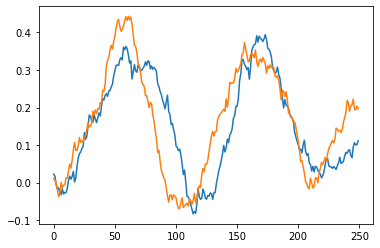

In [16]:
plt.plot(X[:, 0, :, 0]);

In [17]:
# Create theano backend functions
template_dfun = """
           import theano
           import theano.tensor as tt
           import numpy as np
           <%include file="theano-dfuns.py.mako"/>
           """
dfun = TheanoBackend().build_py_func(template_source=template_dfun, content=dict(sim=sim), 
                                     name="dfuns", print_source=True)

template_cfun = f"""
           import theano
           import theano.tensor as tt
           import numpy as np
           n_node = {sim.connectivity.number_of_regions}
           <%include file="theano-coupling.py.mako"/>
           """

cfun = TheanoBackend().build_py_func(template_source=template_cfun, content=dict(sim=sim), 
                                     name="coupling", print_source=True)

001	
002	import theano
003	import theano.tensor as tt
004	import numpy as np
005	#
006	#
007	# TheVirtualBrain-Scientific Package. This package holds all simulators, and
008	# analysers necessary to run brain-simulations. You can use it stand alone or
009	# in conjunction with TheVirtualBrain-Framework Package. See content of the
010	# documentation-folder for more details. See also http://www.thevirtualbrain.org
011	#
012	# (c) 2012-2022, Baycrest Centre for Geriatric Care ("Baycrest") and others
013	#
014	# This program is free software: you can redistribute it and/or modify it under the
015	# terms of the GNU General Public License as published by the Free Software Foundation,
016	# either version 3 of the License, or (at your option) any later version.
017	# This program is distributed in the hope that it will be useful, but WITHOUT ANY
018	# WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
019	# PARTICULAR PURPOSE.  See the GNU General Public License

In [18]:
def_std = 0.1

model = pm.Model()
with model:
    a_model_star = pm.Normal(name="a_model_star", mu=0.0, sd=1.0, shape=sim.model.a.shape)
    a_model = pm.Deterministic(name="a_model", var=sim.model.a + def_std * a_model_star)
    
    a_coupling_star = pm.Normal(name="a_coupling_star", mu=0.0, sd=1.0)
    a_coupling = pm.Deterministic(name="a_coupling", 
                                  var=sim.coupling.a[0].item() + def_std * a_coupling_star)
    
    x_init_star = pm.Normal(name="x_init_star", mu=0.0, sd=1.0, 
                            shape=sim.initial_conditions.shape[:-1])
    x_init = pm.Deterministic(name="x_init", 
                              var=sim.initial_conditions[:, :, :, 0] + def_std*x_init_star)
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    nsig_star = BoundedNormal(name="nsig_star", mu=0.0, sd=1.0)
    nsig = pm.Deterministic("nsig", var=def_std * sim.integrator.noise.nsig[0].item() * nsig_star)
    
    dWt_star = pm.Normal(name="dWt_star", mu=0.0, sd=1.0, shape=X.shape[:-1])
    dWt = pm.Deterministic(name='dWt', var=tt.sqrt(2.0 * nsig * sim.integrator.dt) * dWt_star)
        
    amplitude_star = pm.Normal(name="amplitude_star", mu=0.0, sd=1.0)
    amplitude = pm.Deterministic(name="amplitude", var=1.0 + def_std * amplitude_star)

    offset_star = pm.Normal(name="offset_star", mu=0.0, sd=1.0)
    offset = pm.Deterministic(name="offset", var=def_std * offset_star)
    
    observation_noise_star = pm.HalfNormal("observation_noise_star", sd=1.0)
    observation_noise = pm.Deterministic("observation_noise", var=def_std*observation_noise_star)
    

In [19]:
prior = Pymc3Prior(
    model=model,
    names=["model.a", "coupling.a", "x_init", "integrator.noise.nsig", "dWt_star", 
           "observation.model.amplitude", "observation.model.offset", "observation.noise"], 
    dist=[a_model, a_coupling, x_init, nsig, dWt_star, 
          amplitude, offset, observation_noise]
)

In [20]:
def scheme(dWt, *x_prev):
    x_prev = x_prev[::-1]

    state = tt.stack(x_prev, axis=0)
    state = tt.transpose(state, axes=[1, 0, 2])

    cX = tt.zeros((sim.history.n_cvar, sim.history.n_node))
    cX = cfun(cX, sim.connectivity.weights, state, sim.connectivity.delay_indices,
              **prior.get_coupling_params())

    dX = tt.zeros((sim.model.nvar, sim.history.n_node))
    dX = dfun(dX, x_prev[0], cX, sim.model.spatial_parameter_matrix, **prior.get_model_params())
    
    return x_prev[0] + sim.integrator.dt * dX + dWt


In [21]:
# model_builder = StochasticPymc3ModelBuilder(sim=sim, params=prior, 
#                                             observation_fun=linear, observation=X[:, :, :, 0])

pymc_model = Pymc3Model(sim=sim, params=prior)

In [22]:
with stats_model.model:
    
    taps = list(-1 * np.arange(sim.connectivity.idelays.max() + 1) - 1)[::-1]
    x_sim, updates = theano.scan(
                    fn=scheme,
                    sequences=[dWt],
                    outputs_info=[dict(initial=x_init, taps=taps)],
                    n_steps=X.shape[0]
                )
    
    x_hat = pm.Deterministic(name="x_hat",
                             var=linear(x_sim, **prior.get_observation_model_params()))
    
    x_obs = pm.Normal(name="x_obs", mu=x_hat, sd=prior.dict.get("observation.noise", 1.0),
                      shape=X.shape[:-1], observed=X[:, :, :, 0])

In [24]:
pymc_model.model

In [25]:
pymc_estimator = EstimatorPYMC(stats_model=pymc_model)

In [26]:
draws = 500
tune = 500
cores = 2

In [27]:
inference_data = pymc_estimator.run_inference(draws, tune, cores, target_accept=0.9)

/Users/dionperd/Software/TVB/tvb-inversion/tvb_inversion/pymc3/inference.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=draws, tune=tune, cores=cores, target_accept=target_accept)
Auto-assigning NUTS sampler...


06-12-2022 05:35:19 - INFO - pymc3 - Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


06-12-2022 05:35:19 - INFO - pymc3 - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


06-12-2022 05:36:16 - INFO - pymc3 - Multiprocess sampling (2 chains in 2 jobs)


NUTS: [observation_noise_star, offset_star, amplitude_star, dWt_star, nsig_star, x_init_star, a_coupling_star, a_model_star]


06-12-2022 05:36:16 - INFO - pymc3 - NUTS: [observation_noise_star, offset_star, amplitude_star, dWt_star, nsig_star, x_init_star, a_coupling_star, a_model_star]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 26041 seconds.


07-12-2022 12:50:20 - INFO - pymc3 - Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 26041 seconds.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


07-12-2022 12:50:29 - ERROR - pymc3 - There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


07-12-2022 12:50:29 - WARNING - pymc3 - The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


07-12-2022 12:50:29 - WARNING - pymc3 - The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.


07-12-2022 12:50:29 - ERROR - pymc3 - The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.


The estimated number of effective samples is smaller than 200 for some parameters.


07-12-2022 12:50:29 - ERROR - pymc3 - The estimated number of effective samples is smaller than 200 for some parameters.


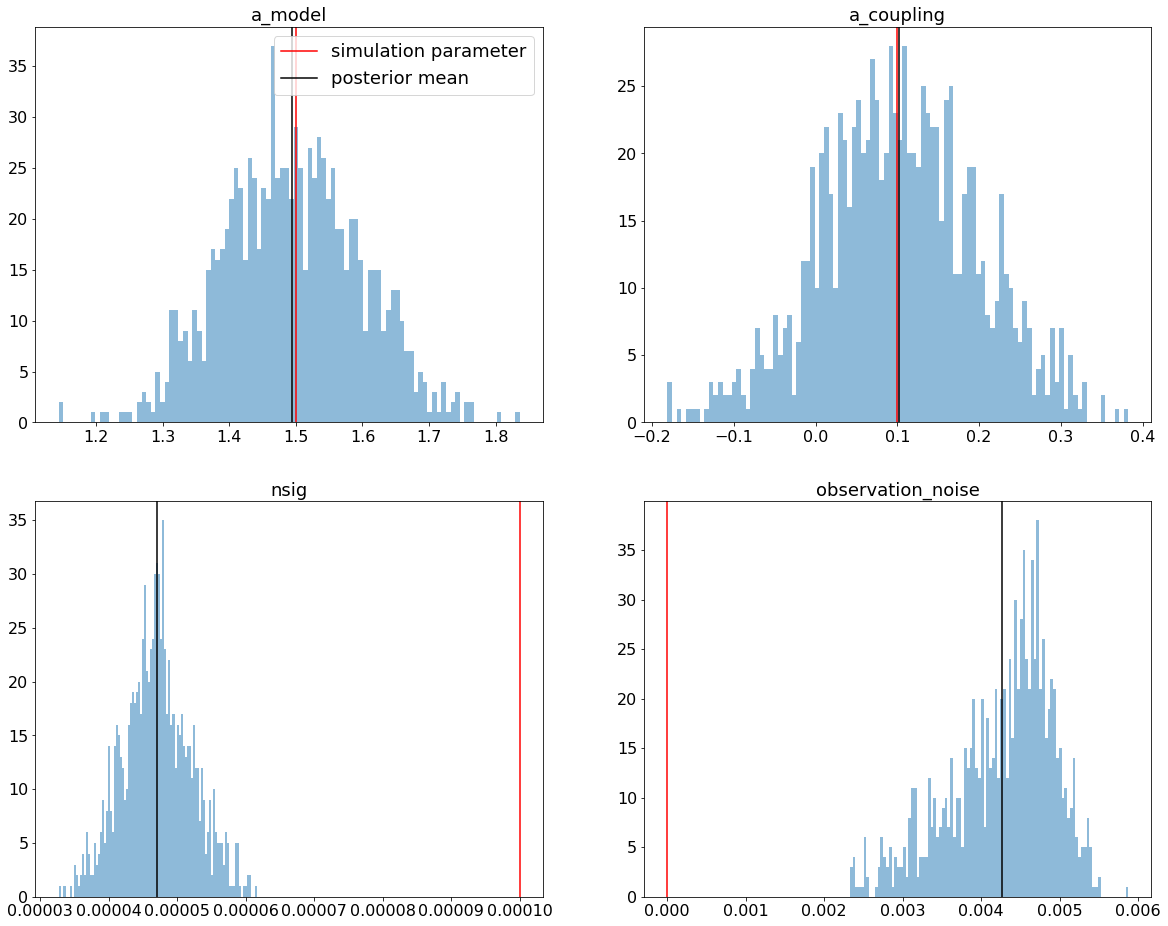

In [47]:
init_params = {
    "a_model": sim.model.a[0],
    "a_coupling": sim.coupling.a[0],
    "nsig": sim.integrator.noise.nsig[0],
    "observation_noise": 0.0
}
plot_posterior_samples(pymc_estimator.inference_data,  init_params)

In [30]:
posterior_x_obs = pymc_estimator.inference_data.posterior_predictive.x_obs.values.reshape((cores*draws, *X.shape[:-1]))


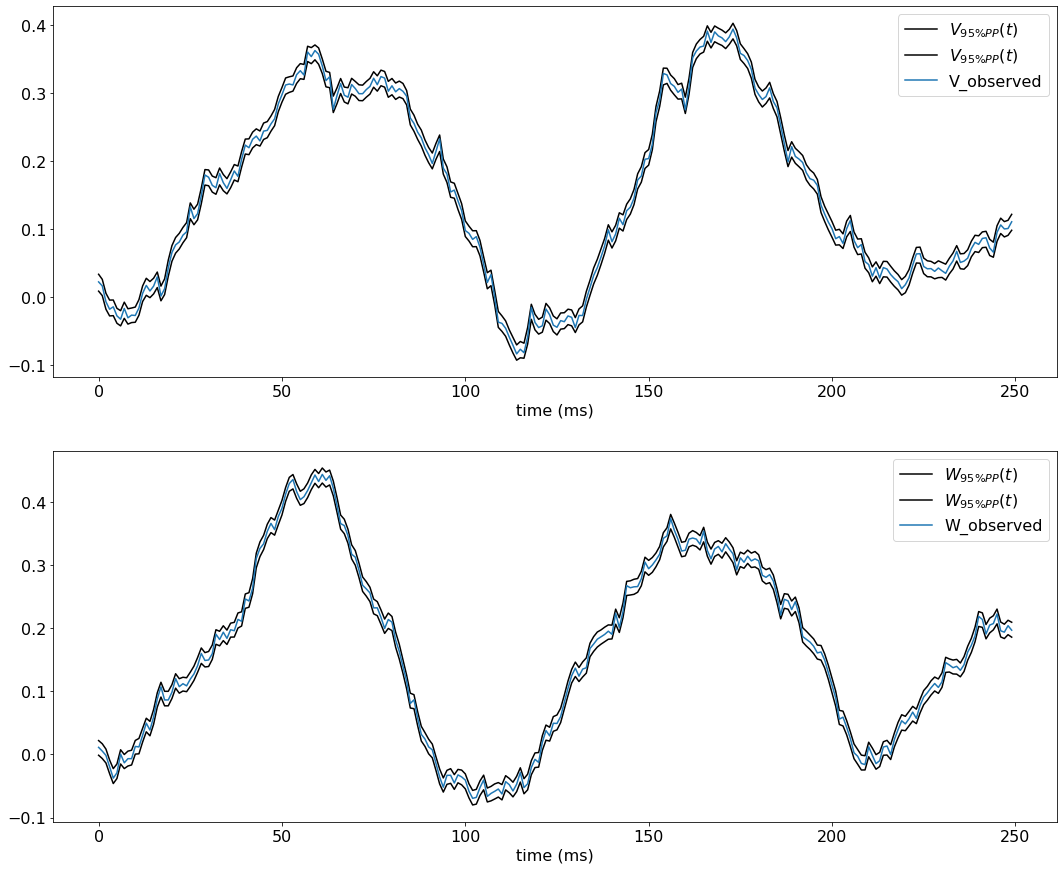

In [31]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0], [2.5, 97.5], axis=0).T, 
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0, 0], label="V_observed")
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 0, 1], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
axes3[1].plot(X[:, 0, 1, 0], label="W_observed")
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [38]:
pymc_estimator.inference_summary.loc[['a_model_star[0]', 'a_coupling_star', 'nsig_star', 
                                      'amplitude_star', 'offset_star', 'observation_noise_star']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_model_star[0],-0.056,1.033,-1.940,1.734,0.044,0.031,546.0,639.0,1.01
a_coupling_star,0.022,0.959,-1.732,1.944,0.043,0.030,503.0,521.0,1.00
nsig_star,4.710,0.502,3.813,5.729,0.074,0.053,48.0,111.0,1.08
amplitude_star,2.664,0.627,1.550,3.809,0.062,0.044,107.0,165.0,1.02
offset_star,-0.358,0.088,-0.525,-0.207,0.010,0.007,88.0,121.0,1.01
observation_noise_star,0.043,0.007,0.030,0.054,0.004,0.003,4.0,19.0,1.45


In [41]:
pymc_estimator.inference_summary.loc[pymc_estimator.inference_summary.index.str.contains("x_init_star")].describe()                        
                                     

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000
mean,0.160625,0.564125,-0.917875,1.178000,0.026625,0.019375,353.000000,446.125000,1.00625
std,0.196451,0.479289,1.115148,0.685753,0.018670,0.013511,249.561329,164.715718,0.00744
min,-0.060000,0.108000,-2.170000,0.472000,0.009000,0.007000,120.000000,253.000000,1.00000
25%,-0.014000,0.117500,-1.912000,0.539000,0.010000,0.007000,138.500000,295.750000,1.00000
50%,0.140000,0.551000,-0.871500,1.144000,0.023500,0.018000,270.000000,433.000000,1.00500
75%,0.319500,1.021500,0.090000,1.790500,0.041250,0.030000,559.500000,571.500000,1.01000
max,0.445000,1.025000,0.250000,1.976000,0.054000,0.038000,744.000000,687.000000,1.02000


In [42]:
pymc_estimator.inference_summary.loc[pymc_estimator.inference_summary.index.str.contains("dWt_star")].describe()


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.017669,0.432293,-0.826905,0.789736,0.023865,0.017246,358.459000,475.421000,1.013300
std,0.924472,0.036098,0.923818,0.922411,0.005738,0.004207,92.427036,109.087111,0.008329
min,-2.979000,0.373000,-3.874000,-2.132000,0.015000,0.011000,30.000000,121.000000,1.000000
25%,-0.642500,0.420000,-1.468500,0.165000,0.021000,0.015000,305.000000,399.750000,1.010000
50%,0.011000,0.430000,-0.821000,0.794500,0.023000,0.016000,362.000000,475.500000,1.010000
75%,0.556250,0.440000,-0.261000,1.382250,0.025000,0.018000,420.000000,546.250000,1.020000
max,3.471000,0.988000,2.647000,4.213000,0.081000,0.058000,822.000000,860.000000,1.070000


In [40]:
pymc_estimator.inference_data.to_netcdf(filename="pymc3_data/test1.nc", compress=False)

PermissionError: [Errno 13] Permission denied: b'/Users/dionperd/Software/TVB/tvb-inversion/notebooks/pymc3_data/test1.nc'